In [1]:
import requests
import pandas as pd
import pandas_ta as ta
import numpy as np
import time
import torch
from typing import Tuple
from abc import ABC, abstractmethod
from typing import Dict, Any, List, Optional, Callable
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows', None)

In [2]:
class IDataFetcher(ABC):
    @abstractmethod
    def fetch(self, start_time: int, end_time: int) -> pd.DataFrame:
        pass

In [3]:
class MarketDataFetcher(IDataFetcher):
    def __init__(
        self,
        api_key: str,
        base_url: str,
        endpoint: str,
        params_template: Dict[str, Any],
        flatten_json: bool = False,
        rename_columns: Optional[Dict[str, str]] = None
    ):
        self.api_key = api_key
        self.base_url = base_url
        self.endpoint = endpoint
        self.params_template = params_template
        self.flatten_json = flatten_json
        self.rename_columns = rename_columns or {}

    def fetch(self, start_time: int, end_time: int) -> pd.DataFrame:
        headers = {"X-API-Key": self.api_key}
        url = f"{self.base_url}/{self.endpoint}"
        params = self.params_template.copy()
        params.update({
            "start_time": start_time,
            "end_time": end_time
        })

        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json().get("data", [])

        # Use flatten if nested JSON
        df = pd.json_normalize(data) if self.flatten_json else pd.DataFrame(data)

        # Add datetime index
        df['datetime'] = pd.to_datetime(df['start_time'], unit='ms')
        df.set_index('datetime', inplace=True)
        df.drop(columns=['start_time'], inplace=True)

        # Rename if required
        df.rename(columns=self.rename_columns, inplace=True)

        return df


In [4]:
def get_cryptoquant_data():
    now = int(time.time() * 1000)
    start_time = now - 6 * 365 * 24 * 60 * 60 * 1000

    api_key = "YBYu4oyUpkxUKi5FVZGxnDRTsBneFjEvxMs55xJHysR6kZf6"

    fetcher = MarketDataFetcher(
        api_key=api_key,
        base_url="https://api.datasource.cybotrade.rs/cryptoquant",
        endpoint="xrp/market-data/price-ohlcv",
        params_template={"window": "hour", "flatten": "true"}
    )
    df = fetcher.fetch(start_time, now)

    return df[["close", "volume"]]

In [5]:
data = get_cryptoquant_data()


In [6]:
class TA_inidicators:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def add_ema(self, length=10):
        self.df[f'ema'] = ta.ema(self.df['close'], length=length)

    def add_rsi(self, length=14):
        self.df[f'rsi'] = ta.rsi(self.df['close'], length=length)

    def add_macd(self, fast=12, slow=26, signal=9):
        macd = ta.macd(self.df['close'], fast=fast, slow=slow, signal=signal)
        self.df = pd.concat([self.df, macd], axis=1)

    def add_bollinger_band_width(self, length=20):
        bbands = ta.bbands(self.df['close'], length=length)
        self.df['bollinger_width'] = bbands[f'BBU_{length}_2.0'] - bbands[f'BBL_{length}_2.0']

    def add_all_indicators(self):
        self.add_ema()
        self.add_rsi()
        self.add_macd()
        self.add_bollinger_band_width()

    def get_dataframe(self):
        return self.df


In [7]:
class combineTA_to_OHLCV:
    def __init__(self, ohlcv_df: pd.DataFrame):
        self.ohlcv_df = ohlcv_df

    def process(self) -> pd.DataFrame:
        indicator_generator = TA_inidicators(self.ohlcv_df)
        indicator_generator.add_all_indicators()
        return indicator_generator.get_dataframe()


In [8]:
data_full = combineTA_to_OHLCV(data).process()
data_full.to_csv("data_full.csv", index=True)


In [9]:
class IPreprocessor(ABC):
    @abstractmethod
    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        pass

In [10]:
class Normalizer:
    def __init__(self):
        self.scaler = MinMaxScaler()

    def process(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, MinMaxScaler]:
        ohlcv_columns = ['close', 'volume', 'ema', 'rsi',
                         'MACD_12_26_9', 'MACDh_12_26_9',
                         'MACDs_12_26_9', 'bollinger_width']
        df[ohlcv_columns] = self.scaler.fit_transform(df[ohlcv_columns])
        return df, self.scaler.data_min_, self.scaler.data_max_, self.scaler



In [11]:
class SequenceCreator:
    def __init__(self, lookback: int = 20):
        self.lookback = lookback

    def create_sequences(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        X, y = [], []
        for i in range(len(df) - self.lookback):
            X.append(df.iloc[i:i + self.lookback].values)  # [lookback, features]
            y.append(df.iloc[i + self.lookback].values)    # [features]
        return np.array(X), np.array(y)  # X: [samples, lookback, features], y: [samples, features]




In [12]:
class MissingTimestampHandler(IPreprocessor):
    def __init__(self, frequency: str = '1h'):
        self.frequency = frequency

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.resample(self.frequency).mean()
        df.interpolate(method='linear', inplace=True)
        return df

In [13]:
class TrainTestSplitter(IPreprocessor):
    def __init__(self, train_ratio: float = 0.7):
        self.train_ratio = train_ratio

    def process(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        split_index = int(len(X) * self.train_ratio)
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]
        return X_train, X_test, y_train, y_test


In [14]:
class DataReshape(IPreprocessor):
    def __init__(self, lookback: int = 20, train_ratio: float = 0.7):
        self.normalizer = Normalizer()
        self.sequence_creator = SequenceCreator(lookback)
        self.splitter = TrainTestSplitter(train_ratio)

    def process(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, MinMaxScaler]:
        df_normalized, data_min, data_max, scaler = self.normalizer.process(df)
        X, y = self.sequence_creator.create_sequences(df_normalized)
        X_train, X_test, y_train, y_test = self.splitter.process(X, y)
        return X_train, X_test, y_train, y_test, data_min, data_max, scaler




In [15]:
def load_dataset(lookback: int = 20, train_ratio: float = 0.7) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, MinMaxScaler]:
    df = get_cryptoquant_data()
    df = combineTA_to_OHLCV(df).process()
    df = df.dropna()
    pipeline = DataReshape(lookback=lookback, train_ratio=train_ratio)
    return pipeline.process(df)


In [16]:
import nbimporter
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import Tuple, Callable
from skopt import gp_minimize
from skopt.space import Integer, Categorical, Real
from sklearn.metrics import r2_score
import torch.nn as nn
from tqdm.auto import tqdm

In [17]:
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, data_min, data_max, scaler = load_dataset()

In [18]:
print(f"X train shape:{X_train_tensor.shape}")
print(f"X test shape:{X_test_tensor.shape}")
print(f"y train shape:{y_train_tensor.shape}")
print(f"y test shape:{y_test_tensor.shape}")

X train shape:(36753, 20, 8)
X test shape:(15752, 20, 8)
y train shape:(36753, 8)
y test shape:(15752, 8)


In [19]:
# Create a function to time our experiments
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout_prob: float = 0.2):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob
        )

        # Attention mechanism
        self.attn_weight = nn.Linear(hidden_size, 1)

        # Output layer: now outputs 8 features
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, input_size),  # output 8 features
            # nn.Sigmoid()  # Uncomment this ONLY if you want outputs in range [0, 1]
        )

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        batch_size = x.shape[0]

        # Initialize hidden and cell states
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        # LSTM output
        lstm_out, _ = self.lstm(x, (h_0, c_0))  # [batch, seq_len, hidden_size]

        # Attention mechanism
        attn_scores = torch.tanh(self.attn_weight(lstm_out))  # [batch, seq_len, 1]
        attn_weights = F.softmax(attn_scores, dim=1)  # [batch, seq_len, 1]
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)  # [batch, hidden_size]

        # Dropout + final output
        out = self.dropout(context_vector)
        out = self.fc(out)  # [batch, 8]
        return out



In [21]:
torch.manual_seed(42)
# Instantiate a sample model for test
model_LSTM = AttentionLSTM(input_size=8, hidden_size=33, num_layers=3, dropout_prob=0.02)

In [22]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr= 0.0003)

In [23]:
def regression_r2(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()

    # Compute R² for each feature separately and average
    r2_scores = [r2_score(y_true_np[:, i], y_pred_np[:, i]) for i in range(y_true_np.shape[1])]
    return torch.tensor(sum(r2_scores) / len(r2_scores))


In [24]:
import torch
from typing import Tuple, Callable
import matplotlib.pyplot as plt


def recursive_forecast(
    model: torch.nn.Module,
    initial_input: torch.Tensor,
    forecast_steps: int,
    lookback: int,
    device: torch.device
) -> torch.Tensor:
    """
    Recursively forecasts future multi-feature values using the trained LSTM model.

    Args:
        model: Trained LSTM model
        initial_input: Tensor of shape [1, lookback, num_features]
        forecast_steps: Number of future steps to predict
        lookback: Length of input window
        device: CPU or CUDA

    Returns:
        forecast: Tensor of shape [forecast_steps, output_dim]
    """
    model.eval()
    forecast = []

    current_input = initial_input.clone().to(device)

    with torch.inference_mode():
        for _ in range(forecast_steps):
            pred = model(current_input)  # [1, output_dim] -> [1, 8]
            forecast.append(pred.squeeze(0))  # [8]

            # Replace last step with predicted features
            new_step = pred.unsqueeze(1)  # [1, 1, 8]
            current_input = torch.cat([current_input[:, 1:], new_step], dim=1)  # slide window

    return torch.stack(forecast)  # [forecast_steps, 8]


def evaluate_forecast(
    forecast: torch.Tensor,
    ground_truth: torch.Tensor,
    loss_fn: torch.nn.Module,
    metrics_fn: Callable[[torch.Tensor, torch.Tensor], float] = None
) -> Tuple[float, float]:
    """
    Compares forecast with ground truth and computes evaluation metrics.

    Args:
        forecast: Tensor of predicted values [forecast_steps, output_dim]
        ground_truth: Tensor of true values [forecast_steps, output_dim]
        loss_fn: Loss function (e.g. MSE)
        metrics_fn: Optional function to compute additional metrics like R^2

    Returns:
        loss_value, metrics_value
    """
    loss_value = loss_fn(forecast, ground_truth).item()
    metrics_value = metrics_fn(forecast, ground_truth).item() if metrics_fn else None
    return loss_value, metrics_value



In [25]:
from sklearn.metrics import r2_score
import torch.nn as nn

def run_training_and_testing(
    model: torch.nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    lookback: int,
    device: torch.device,
    epochs: int = 100,
    lr: float = 0.001,
):
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    # Define loss and optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    # Begin training loop
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()

        # Forward pass
        y_pred_train = model(X_train)
        train_loss = loss_fn(y_pred_train, y_train)

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Evaluate every 20 epochs
        if epoch % 20 == 0 or epoch == epochs:
            with torch.inference_mode():
                # Forecast using recursive strategy
                initial_input = X_test[0].unsqueeze(0)  # [1, lookback, features]
                forecast_steps = len(y_test)
                y_pred_test = recursive_forecast(model, initial_input, forecast_steps, lookback, device)

                # Evaluate y_pred_test
                test_loss, test_r2 = evaluate_forecast(y_pred_test, y_test[:forecast_steps], loss_fn, regression_r2)

                print(f"Epoch [{epoch}/{epochs}]")
                print(f"  Train Loss: {train_loss.item():.5f}")
                print(f"  Test Loss:  {test_loss:.5f} | R² Score: {test_r2:.4f}")

    return model, y_pred_train, y_pred_test, train_loss, test_loss, test_r2


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Measure time
from timeit import default_timer as timer
train_time_start_model_0 = timer()

trained_model, y_pred_train, y_pred_test, train_loss, test_loss, test_r2 = run_training_and_testing(
    model=model_LSTM,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    lookback=20,
    device=device,
    epochs=100
)

train_time_end_model_0 = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_model_0,
                                            end=train_time_end_model_0,
                                            device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20/100]
  Train Loss: 0.03629
  Test Loss:  0.05849 | R² Score: -29075052.0726
Epoch [40/100]
  Train Loss: 0.00666
  Test Loss:  0.02577 | R² Score: -100165337.2604
Epoch [60/100]
  Train Loss: 0.00489
  Test Loss:  0.02377 | R² Score: -67212723.0392
Epoch [80/100]
  Train Loss: 0.00472
  Test Loss:  0.02314 | R² Score: -312812759.9296
Epoch [100/100]
  Train Loss: 0.00463
  Test Loss:  0.02319 | R² Score: -211490301.8695
Train time on cpu: 422.589 seconds


In [27]:
def denormalize(data, scaler: MinMaxScaler) -> np.ndarray:
    """
    Denormalizes data using the given scaler.

    Args:
        data (torch.Tensor or np.ndarray): Normalized data
        scaler (MinMaxScaler): Scaler used during normalization

    Returns:
        np.ndarray: Denormalized data
    """
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()
    return scaler.inverse_transform(data)



In [28]:
# Denormalize true and predicted values
y_train_true_denorm = denormalize(y_train_tensor, scaler)
y_train_pred_denorm = denormalize(y_pred_train, scaler)

y_test_true_denorm = denormalize(y_test_tensor, scaler)
y_test_pred_denorm = denormalize(y_pred_test, scaler)


In [41]:
from skopt import gp_minimize
from skopt.space import Integer, Categorical
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the objective function for Bayesian Optimization
def objective(params):
    # Extract parameters
    num_layers = int(params[0])
    hidden_size = int(params[1])
    lookback = int(params[2])
    batch_size_bo = int(params[3])
    optimizer_name = params[4]

    X_train_t = torch.FloatTensor(X_train_tensor)
    y_train_t = torch.FloatTensor(y_train_tensor)
    X_test_t = torch.FloatTensor(X_test_tensor)
    y_test_t = torch.FloatTensor(y_test_tensor)
    
    # Model initialization
    model = AttentionLSTM(
        input_size=8,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_prob=0.2  # Fixed dropout
    ).to(device)
    
    # Optimizer selection
    if optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif optimizer_name == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters())
    
    # Training loop (limited epochs for optimization)
    model.train()
    batch_size_bo = 32
    for epoch in range(10):  # Reduced epochs for faster optimization
        for i in range(0, len(X_train_t), batch_size_bo):
            inputs = X_train_t[i:i+batch_size_bo].to(device)
            labels = y_train_t[i:i+batch_size_bo].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        test_preds = recursive_forecast(
            model, 
            X_test_t[0:1],  # Initial sequence
            len(X_test_t),
            lookback,
            device
        )
        val_loss = nn.MSELoss()(test_preds, y_test_t).item()
    
    return val_loss

In [42]:
# Define search space
param_space = [
    Integer(1, 3, name='num_layers'),          # LSTM layers
    Integer(32, 256, name='hidden_size'),      # Hidden units
    Integer(60, 90, name='lookback'),          # Sequence length
    Integer(32, 256, name='batch_size'),       # Batch size
    Categorical(['adam', 'rmsprop'], name='optimizer')  # Optimizer
]

In [43]:
# Run optimization
res = gp_minimize(
    objective,
    param_space,
    n_calls=20,               # Reduced from 30
    random_state=42,
    verbose=True,
    n_jobs=-1                # Parallel processing
)

# Best parameters
print(f"Best parameters: {res.x}")
print(f"Best validation MSE: {res.fun}")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 181.8271
Function value obtained: 0.0235
Current minimum: 0.0235
Iteration No: 2 started. Evaluating function at random point.


c:\Users\User\Anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 94.9729
Function value obtained: 0.0228
Current minimum: 0.0228
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 125.0853
Function value obtained: 0.0232
Current minimum: 0.0228
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 213.2013
Function value obtained: 0.0234
Current minimum: 0.0228
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 108.7521
Function value obtained: 0.0236
Current minimum: 0.0228
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 156.7443
Function value obtained: 0.0234
Current minimum: 0.0228
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Eva

c:\Users\User\Anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 208.5988
Function value obtained: 0.0238
Current minimum: 0.0228
Iteration No: 14 started. Searching for the next optimal point.


c:\Users\User\Anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 83.1517
Function value obtained: 0.0228
Current minimum: 0.0228
Iteration No: 15 started. Searching for the next optimal point.


c:\Users\User\Anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 161.8008
Function value obtained: 0.0229
Current minimum: 0.0228
Iteration No: 16 started. Searching for the next optimal point.


c:\Users\User\Anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 59.2099
Function value obtained: 0.0229
Current minimum: 0.0228
Iteration No: 17 started. Searching for the next optimal point.


c:\Users\User\Anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 92.8623
Function value obtained: 0.0230
Current minimum: 0.0228
Iteration No: 18 started. Searching for the next optimal point.


c:\Users\User\Anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 98.7948
Function value obtained: 0.0237
Current minimum: 0.0228
Iteration No: 19 started. Searching for the next optimal point.


c:\Users\User\Anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 73.0746
Function value obtained: 0.0232
Current minimum: 0.0228
Iteration No: 20 started. Searching for the next optimal point.


c:\Users\User\Anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 95.9687
Function value obtained: 0.0234
Current minimum: 0.0228
Best parameters: [1, 135, 70, 64, 'rmsprop']
Best validation MSE: 0.022796981036663055


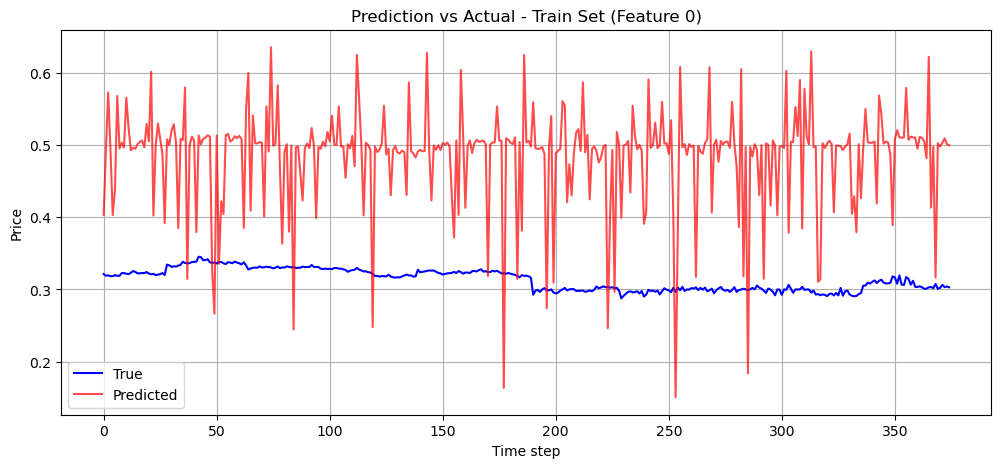

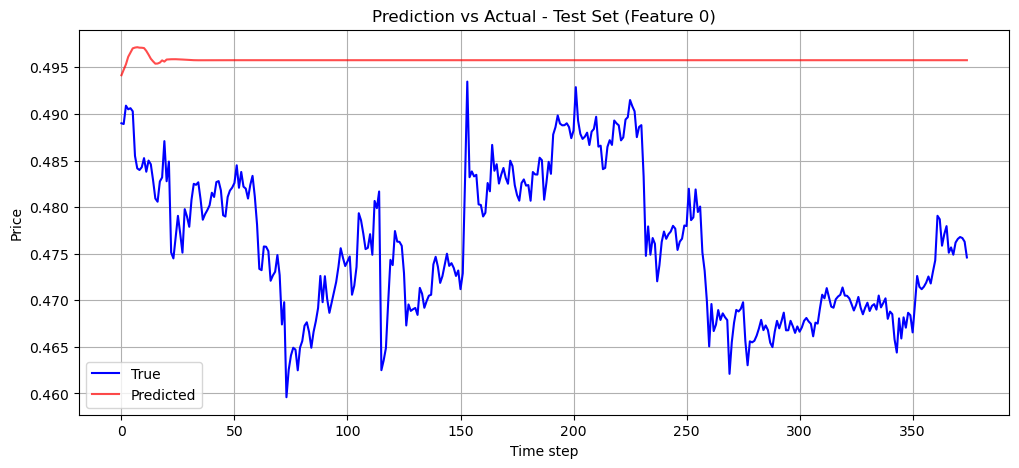

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(true_vals, predicted_vals, title='Prediction vs Actual', feature_idx=0, dataset_type='Train'):
    plt.figure(figsize=(12, 5))
    plt.plot(true_vals[:375, feature_idx], label='True', color='blue')
    plt.plot(predicted_vals[:375, feature_idx], label='Predicted', color='red', alpha=0.7)
    plt.title(f'{title} - {dataset_type} Set (Feature {feature_idx})')
    plt.xlabel('Time step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plot for 'close' price (assuming it's feature 0)
plot_predictions(y_train_true_denorm, y_train_pred_denorm, dataset_type='Train', feature_idx=0)
plot_predictions(y_test_true_denorm, y_test_pred_denorm, dataset_type='Test', feature_idx=0)
